In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager
from datetime import datetime
import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Tennis')

In [3]:
data = dm.__get_data__()

KeyboardInterrupt: 

In [ ]:
data = data[data[('odds', 0)] != data[('odds', 1)]]
data.tail()

In [ ]:
train = data[data.index.get_level_values(0) < datetime(2019, 1, 1)]
test  = data[data.index.get_level_values(0) > datetime(2019, 1, 1)]

In [6]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 0), ('prob', 1), 'FTR'])

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [7]:
matrix.head()

FTR                     0      1
(prob, 0) (prob, 1)             
0.01      0.99        0.0   38.0
0.02      0.98        3.0  209.0
0.03      0.97        4.0  274.0
0.04      0.96       21.0  612.0
0.05      0.95       35.0  993.0

In [8]:
vicini = test.prob[[0, 1]].apply(get_neighbours, axis=1).rename('NN').to_frame()
probs  = vicini.apply(dm.ubibetter.__compute_probs_avg__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [9]:
aux = pd.concat([test.odds.stack().rename('odd'), 
                 probs.KLFY.stack().rename('prob')], 
                axis=1, join='inner')
aux = aux.reset_index(level=4).merge(test['FTR'], right_index=True, left_index=True)

In [10]:
aux.head(6)

level_4   odd      prob  FTR
MatchDate  Winner          Loser     bkmr                              
2019-01-02 Anderson K.     Djere L.  B365        0  3.75  0.232894    1
                                     B365        1  1.25  0.767106    1
                                     PS          0  3.51  0.258386    1
                                     PS          1  1.35  0.741614    1
           Basilashvili N. Rublev A. B365        0  2.00  0.477990    0
                                     B365        1  1.72  0.522010    0

### Attempt for multiple bookmaker bet

In [11]:
levels = [0, 1, 2, 3]
frac = aux.set_index('level_4', append=True)
frac = frac.groupby(level=levels).apply(compute_fraction)
frac = frac.stack().rename('frac').reset_index(level=4)
frac = frac.round(4)

In [12]:
frac.head()

level_4    frac
MatchDate  Winner          Loser     bkmr                 
2019-01-02 Anderson K.     Djere L.  B365        0  0.0000
                                     B365        1  0.0000
                                     PS          0  0.0000
                                     PS          1  0.0034
           Basilashvili N. Rublev A. B365        0  0.0000

In [13]:
aux = pd.concat([aux.set_index('level_4', append=True), 
                 frac.set_index('level_4', append=True)], axis=1)
aux = aux.reset_index(level=4)

In [14]:
aux[aux.frac > 0].head()

level_4   odd      prob  \
MatchDate  Winner           Loser           bkmr                            
2019-01-02 Anderson K.      Djere L.        PS          1  1.35  0.741614   
           Basilashvili N.  Rublev A.       PS          0  2.09  0.516432   
           Bautista Agut R. Garcia-Lopez G. PS          1  1.24  0.808187   
           Cecchinato M.    Pella G.        PS          0  2.07  0.516432   
           Chardy J.        Kyrgios N.      PS          1  1.40  0.719877   

                                                  FTR    frac  
MatchDate  Winner           Loser           bkmr               
2019-01-02 Anderson K.      Djere L.        PS      1  0.0034  
           Basilashvili N.  Rublev A.       PS      0  0.0728  
           Bautista Agut R. Garcia-Lopez G. PS      1  0.0090  
           Cecchinato M.    Pella G.        PS      0  0.0645  
           Chardy J.        Kyrgios N.      PS      0  0.0196

In [15]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [16]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

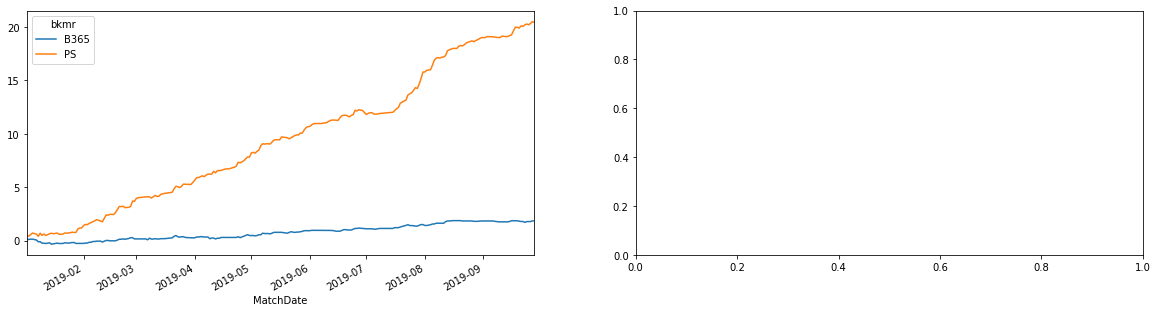

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

select_date = (aux.index.get_level_values(0) >= datetime(2019, 1, 1))
select_odds = aux.odd  > 1.7
select_frac = aux.frac > 0

aux[select_frac & select_date & select_odds].margin.groupby(level=[0,3]).sum().unstack().fillna(0).cumsum().plot(ax=ax[0])
#aux[select_frac & select_date & select_odds].margin.groupby(level=[0,3]).sum().unstack().fillna(0).cumsum().plot(kind='area', ax=ax[1])
plt.show()

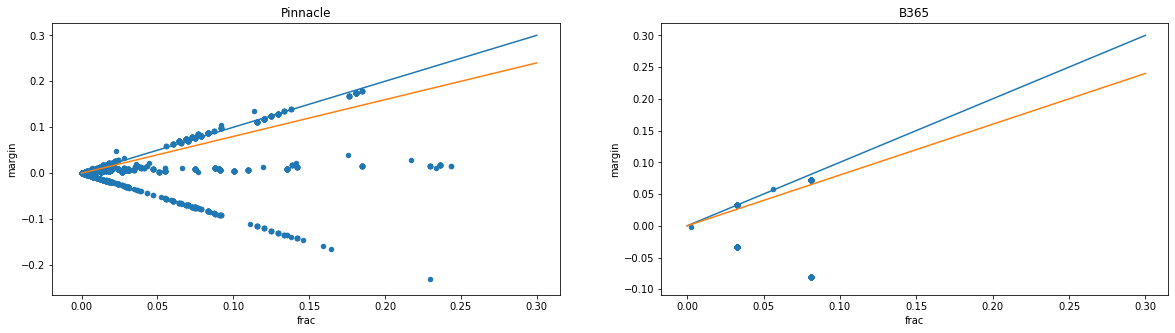

In [18]:
fig ,ax = plt.subplots(1, 2, figsize = (20, 5))
aux[(aux.margin != 0) & (aux.index.get_level_values(3) == 'PS')].plot.scatter(x='frac', y='margin', ax=ax[0], title = 'Pinnacle')
aux[(aux.margin != 0) & (aux.index.get_level_values(3) == 'B365')].plot.scatter(x='frac', y='margin', ax=ax[1], title = 'B365')

ax[0].plot([0, 0.3], [0, 0.3])
ax[0].plot([0, 0.3], [0, 0.3 * 0.8])

ax[1].plot([0, 0.3], [0, 0.3])
ax[1].plot([0, 0.3], [0, 0.3 * 0.8])

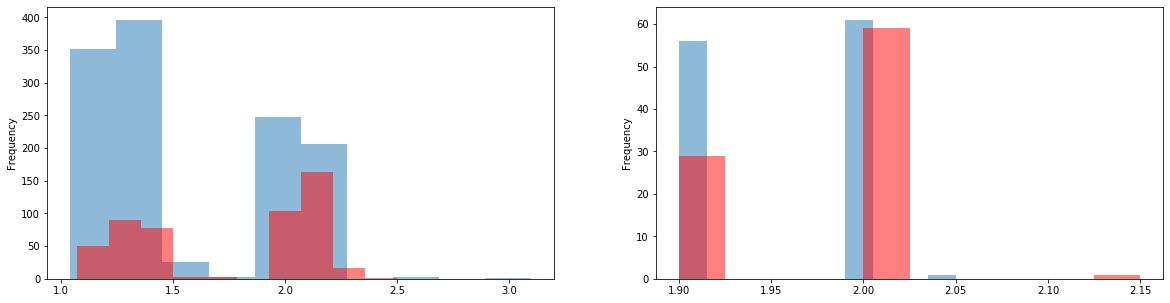

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
select_pos = (aux.margin > 0) & (aux.odd < 5) & (aux.odd > 1)
select_neg = (aux.margin < 0) & (aux.odd < 5) & (aux.odd > 1)

aux[select_pos & (aux.index.get_level_values(3) == 'PS')].odd.plot(kind='hist', ax=ax[0], alpha=0.5, bins=10)
aux[select_neg & (aux.index.get_level_values(3) == 'PS')].odd.plot(kind='hist', ax=ax[0], alpha=0.5, color='red', bins=10)
aux[select_pos & (aux.index.get_level_values(3) == 'B365')].odd.plot(kind='hist', ax=ax[1], alpha=0.5, bins=10)
aux[select_neg & (aux.index.get_level_values(3) == 'B365')].odd.plot(kind='hist', ax=ax[1], alpha=0.5, color='red', bins=10)

plt.show()

In [20]:
aux[(aux.index.get_level_values(3) == 'PS')& (aux.frac > 0)].odd.max()

36.83

ValueError: When stacked is True, each column must be either all positive or negative.PS contains both positive and negative values

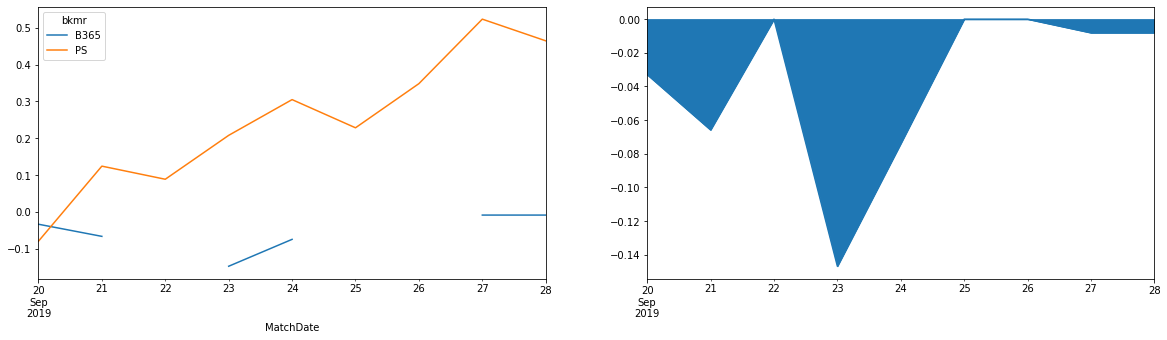

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

select_date = (aux.index.get_level_values(0) >= datetime(2019, 9, 20))
select_odds = aux.odd  > 1.7
select_frac = aux.frac > 0

aux[select_date & select_odds & select_frac].margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux[select_date & select_odds & select_frac].margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(kind='area', ax=ax[1])

In [23]:
aux[select_date & select_odds & select_frac].to_csv('./last_week_matches.csv')